In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import requests
import json
from pybaseball import retrosheet

pd.set_option('display.max_columns', None)

In [2]:
raw_data = pd.read_csv('data/PitchData_21(2).csv')

/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (61) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data = raw_data.copy()

In [4]:
# change starTime and endTime into timestamps

for index, row in data.iterrows():
    startTime = pd.Timestamp(row.startTime)
    endTime = pd.Timestamp(row.endTime)
    startDate = startTime.date()
    endDate = endTime.date()
    data.at[index, 'startTime'] = startTime
    data.at[index, 'startDate'] = startDate
    data.at[index, 'endTime'] = endTime
    data.at[index, 'endDate'] = endDate

In [5]:
data['startTime'].isna().sum()

0

In [6]:
data['endTime'].isna().sum()

14

In [7]:
data_dropped = data[~data['endTime'].isna()].copy()
data_dropped.drop(columns=data_dropped.columns[0], inplace=True)

# group by Game

In [8]:
data_game = data_dropped.groupby('game_pk').agg({'game_date':max, 'home_team':max, 'away_team':max,
                                        'result.eventType': max, 'about.inning':max,
                                        'startTime':min, 'endTime':max, 'startDate':min, 'endDate':max})
data_game = data_game.reset_index()

In [9]:
data_game['diff_min'] = data_game['endTime'] - data_game['startTime']
data_game['diff_min']=data_game['diff_min']/np.timedelta64(1,'m')

In [10]:
data_game.shape

(2429, 11)

In [11]:
data_game['diff_min'].mean()

317.9976126183622

In [12]:
# avg game time when games with different start/end date are removed
data_game[data_game['startDate']==data_game['endDate']]['diff_min'].mean()

190.60921036064826

In [13]:
data_game['diff_min'].sum()

772416.20105

In [14]:
data_game['game_pk'].nunique()

2429

# create list of games that start and end on different date

In [15]:
diff_date = data_game[data_game['startDate']!=data_game['endDate']]['game_pk'].unique()
len(diff_date)

867

In [16]:
data_game_dropped = data_game[~data_game['game_pk'].isin(diff_date)].copy()
data_game_dropped['game_pk'].nunique()

1562

# group by PA

In [17]:
data_pa = data_dropped.groupby(['game_pk','atBatIndex']).agg({'result.eventType':max,
                                                    'game_date':max, 'home_team':max, 'away_team':max,
                                                    'result.eventType': max,
                                                    'startTime':min,'startDate':min, 'endTime':max, 'endDate':max,
                                                   'about.inning':max, 'about.halfInning':max,
                                                    'matchup.splits.menOnBase':max, 'details.isInPlay':max})
data_pa = data_pa.reset_index()

In [18]:
data_pa.rename(columns={'result.eventType':'eventType', 
                     'about.inning': 'inning', 'about.halfInning':'halfInning',
                       'matchup.splits.menOnBase':'menOnBase', 'details.isInPlay':'isInPlay'}, inplace=True)

In [19]:
data_pa['diff_min'] = data_pa['endTime'] - data_pa['startTime']
data_pa['diff_min']=data_pa['diff_min']/np.timedelta64(1,'m')

# drop pa with game_pk in the diff_date

In [20]:
data_pa_dropped = data_pa[~data_pa['game_pk'].isin(diff_date)].copy()
data_pa_dropped['game_pk'].nunique()

1562

In [21]:
data_pa_dropped['diff_min'].sum()/data_pa_dropped['game_pk'].nunique()

101.63047001707213

# calculate pause time

In [22]:
num_game = data_game_dropped['game_pk'].nunique()
num_game

1562

In [23]:
data_game_dropped['diff_min'].sum()/num_game

190.60921036064875

# average pause time: game on the same date

In [24]:
(data_game_dropped['diff_min'].sum() - data_pa_dropped['diff_min'].sum())/num_game

88.9787403435766

# event time and prob

In [25]:
# event probability
event_chart = data_pa['eventType'].value_counts().rename_axis('event').reset_index(name='counts')
event_chart['prob'] = event_chart['counts']/event_chart['counts'].sum()
event_chart

,event,counts,prob
0,field_out,70948,0.389544
1,strikeout,42036,0.230801
2,single,25006,0.137297
3,walk,15091,0.082858
4,double,7863,0.043172
5,home_run,5944,0.032636
6,force_out,3727,0.020463
7,grounded_into_double_play,3313,0.018190
8,hit_by_pitch,2112,0.011596
9,field_error,1243,0.006825


In [26]:
# make list of event
event_list = event_chart['event'].unique()

In [27]:
# calculate avg event time
for event in event_list:
    avg_min = data_pa_dropped[data_pa_dropped['eventType'] == event]['diff_min'].mean()
    event_chart.loc[event_chart['event']==event, 'avgTime'] = avg_min
    event_chart.loc[event_chart['event']==event, 'medTime'] = data_pa[data_pa['eventType']==event]['diff_min'].median()

In [28]:
event_chart

,event,counts,prob,avgTime,medTime
0,field_out,70948,0.389544,1.112635,0.917175
1,strikeout,42036,0.230801,1.736027,1.561142
2,single,25006,0.137297,1.143888,0.953817
3,walk,15091,0.082858,2.150663,1.938300
4,double,7863,0.043172,1.205817,0.990300
5,home_run,5944,0.032636,1.414192,1.201350
6,force_out,3727,0.020463,1.189222,0.987700
7,grounded_into_double_play,3313,0.018190,1.190220,0.967817
8,hit_by_pitch,2112,0.011596,1.026117,0.851558
9,field_error,1243,0.006825,1.128556,0.982533


In [29]:
(event_chart['prob'] * event_chart['avgTime']).sum()

1.362687085377666

In [30]:
num_pa = data_pa.shape[0]/2429
num_pa

74.98188554960889

In [31]:
# expected play time
play_time = (num_pa * event_chart['prob'] * event_chart['avgTime']).sum()
print(f"Expected Play Time: {play_time}")

Expected Play Time: 102.1768470757183


In [32]:
# avg pause time
avg_pause = (data_game_dropped['diff_min'].sum() - data_pa_dropped['diff_min'].sum())/num_game
print(f"Avg Pause Time: {avg_pause}")

Avg Pause Time: 88.9787403435766


In [33]:
# expected total
print(f"Total: {play_time + avg_pause}")

Total: 191.1555874192949


# drop pitches from from different date games

In [34]:
data_dropped = data_dropped[~data_dropped['game_pk'].isin(diff_date)].copy()
data_dropped['game_pk'].nunique()

1562

In [35]:
data_dropped['diff_min'] = data_dropped['endTime'] - data_dropped['startTime']
data_dropped['diff_min']=data_dropped['diff_min']/np.timedelta64(1,'m')

In [36]:
data_dropped.rename(columns={'result.eventType':'eventType', 
                     'about.inning': 'inning', 'about.halfInning':'halfInning',
                       'matchup.splits.menOnBase':'menOnBase', 'details.isInPlay':'isInPlay'}, inplace=True)

# in play pct on different situation

In [37]:
# no runner on base, less than 12 sec, # pitch in play:
under12InPlay = data_dropped[(data_dropped['menOnBase']=='Empty')&(data_dropped['isInPlay']==True)&(data_dropped['diff_min']<0.15)].shape[0]
under12InPlay

28023

In [38]:
# no runner on base, less than 12 sec, # pitch total:
under12Total = data_dropped[(data_dropped['menOnBase']=='Empty')&(data_dropped['diff_min']<0.15)].shape[0]
under12Total

233775

In [39]:
print(f"Pct under: {under12InPlay/under12Total}")

Pct under: 0.11987167147898621


In [40]:
# no runner on base, >= than 12 sec, # pitch in play:
over12InPlay = data_dropped[(data_dropped['menOnBase']=='Empty')&(data_dropped['isInPlay']==True)&(data_dropped['diff_min']>=0.15)].shape[0]
over12InPlay

16848

In [41]:
# no runner on base, >= than 12 sec, # pitch total:
over12Total = data_dropped[(data_dropped['menOnBase']=='Empty')&(data_dropped['diff_min']>=0.15)].shape[0]
over12Total

19670

In [42]:
print(f"Pct over: {over12InPlay/over12Total}")

Pct over: 0.856532791052364


In [43]:
pitch_inPlay = data_dropped[(data_dropped['menOnBase']=='Empty')&(data_dropped['isInPlay']==True)]

In [44]:
pitch_inPlay.shape

(44871, 136)

In [45]:
data_dropped[data_dropped['menOnBase']=='Empty'].shape

(253445, 136)

In [46]:
data_dropped[(data_dropped['menOnBase']=='Empty')&(data_dropped['isInPlay']==True)]['diff_min'].min()

0.05

<AxesSubplot:xlabel='diff_min', ylabel='Count'>

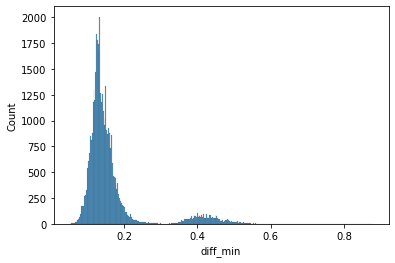

In [47]:
sns.histplot(data=pitch_inPlay, x='diff_min')